In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 14.4 MB/s eta 0:00:00


In [3]:
import torch.optim as optim
import optuna

In [4]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using device : {device}")

Using device : cuda


In [5]:
torch.manual_seed(42)

In [6]:
import kagglehub
path = kagglehub.dataset_download("zalando-research/fashionmnist")
df = pd.read_csv(path + '/fashion-mnist_train.csv')

Using Colab cache for faster access to the 'fashionmnist' dataset.


In [7]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


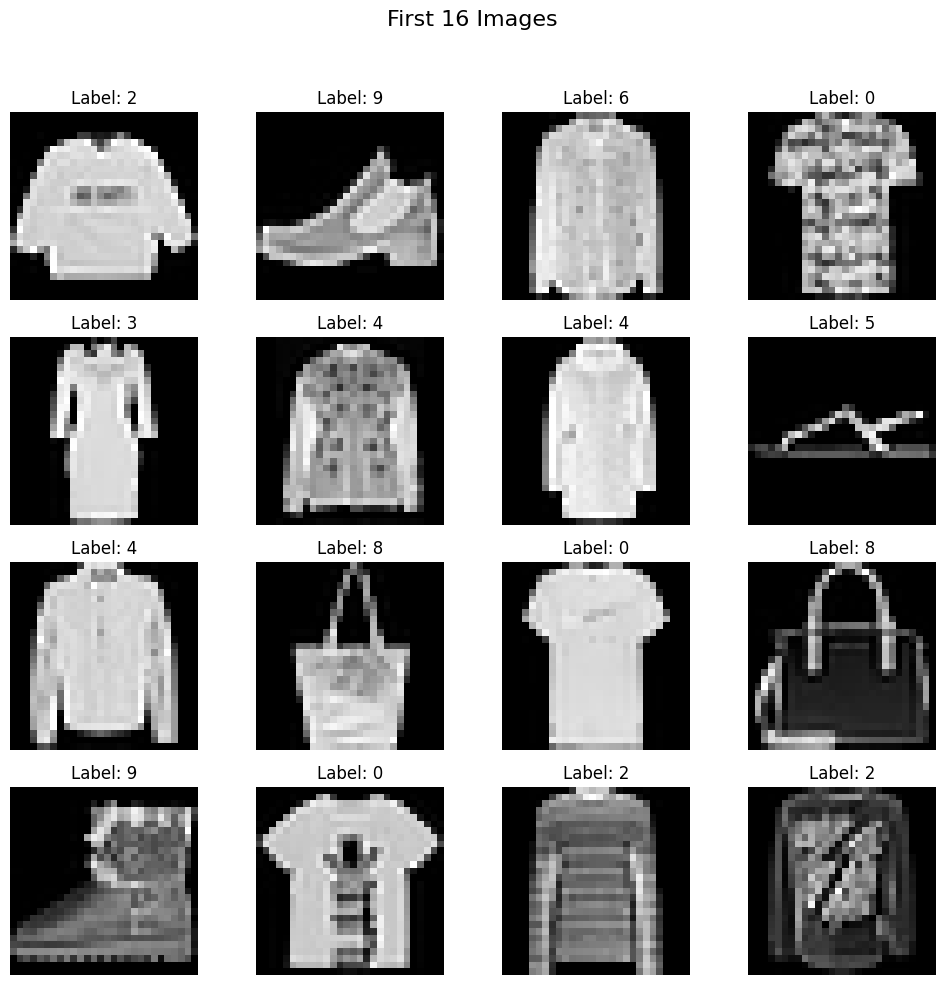

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plotting the images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i, 0]}")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # top reserved for title
plt.show()

In [9]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train = X_train/255.0
X_test = X_test/255.0

In [12]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [13]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)



In [ ]:
class MyNN(nn.Module):

    def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
    
        super().__init__()

        layers = []

        for i in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim, neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = neurons_per_layer

        layers.append(nn.Linear(neurons_per_layer, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):

        return self.model(x)

In [15]:
def Objective(trial):

    train_losses = []

    # Hyperparameters
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
    neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
    epochs = trial.suggest_int("epochs", 10, 50, step=10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    # DataLoaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
    )

    # Model
    input_dim = 784
    output_dim = 10
    model = MyNN(
        input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate
    ).to(device)

    # Loss
    criterion = nn.CrossEntropyLoss().to(device)

    # Optimizer
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

    # Save losses for plotting
    trial.set_user_attr("train_losses", train_losses)

    # Evaluation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            total += y.size(0)
            correct += (preds == y).sum().item()

    accuracy = correct / total
    return accuracy


In [16]:
study = optuna.create_study(direction="maximize")
study.optimize(Objective, n_trials=10)

[I 2025-12-22 16:58:43,889] A new study created in memory with name: no-name-1387fa14-dfa1-4ee2-b741-10954fab2fe5
[I 2025-12-22 16:59:31,330] Trial 0 finished with value: 0.8714166666666666 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 56, 'epochs': 30, 'learning_rate': 0.0007989311629112883, 'dropout_rate': 0.4, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 0.00010618406245709304}. Best is trial 0 with value: 0.8714166666666666.
[I 2025-12-22 17:01:32,828] Trial 1 finished with value: 0.6540833333333333 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 8, 'epochs': 50, 'learning_rate': 0.0001336219990578626, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 2.0523651516967102e-05}. Best is trial 0 with value: 0.8714166666666666.
[I 2025-12-22 17:02:15,023] Trial 2 finished with value: 0.8095 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 64, 'epochs': 30, 'learning_rate': 0.0001983221145509202, 'dropo

In [17]:
best_trial = study.best_trial
losses = best_trial.user_attrs["train_losses"]

In [26]:
study.best_params

{'num_hidden_layers': 2,
 'neurons_per_layer': 72,
 'epochs': 50,
 'learning_rate': 7.352749120685938e-05,
 'dropout_rate': 0.4,
 'batch_size': 32,
 'optimizer': 'Adam',
 'weight_decay': 6.514440425158532e-05}

In [27]:
study.best_value

0.88075

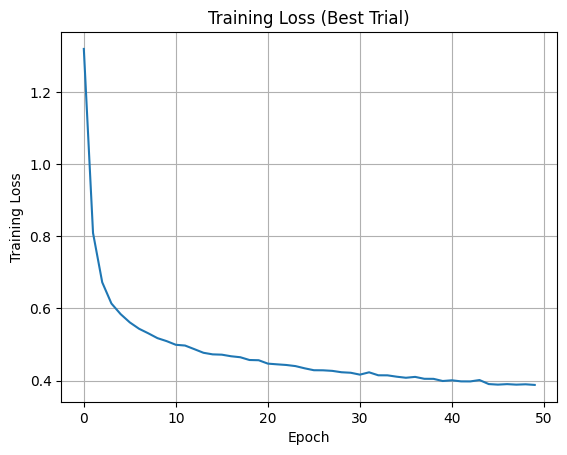

In [18]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss (Best Trial)")
plt.grid(True)
plt.show()

In [19]:
# # Defining NN class
# class MyNN(nn.Module):
    
#     def __init__(self, num_features):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(num_features, 128),
#             nn.BatchNorm1d(128),        #OPTIM :  BATCH NORMALIZATION
#             nn.ReLU(),
#             nn.Dropout(p=0.3),           #OPTIMIZATION : DROPOUT LAYER
#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),          #OPTIM : BATCH NORMALIZATION
#             nn.ReLU(),
#             nn.Dropout(p=0.3),           #OPTIMIZATION : DROPOUT LAYER
#             nn.Linear(64, 10)
#         )

#     def forward(self, x):
#         return self.model(x)

In [20]:
# # set Learning Rate
# epochs = 100
# learning_rate = 0.1

In [21]:
# model = MyNN(X_train.shape[1]).to(device)
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay= 1e-4)

In [22]:
# train_losses = []

# for epoch in range(epochs):

#     total_epochs_loss = 0

#     for batch_features, batch_labels in train_loader:

#         batch_features = batch_features.to(device)
#         batch_labels = batch_labels.to(device)

#         outputs = model(batch_features)
#         loss = criterion(outputs, batch_labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_epochs_loss += loss.item()

#     avg_loss = total_epochs_loss / len(train_loader)
#     train_losses.append(avg_loss)

#     print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


In [23]:
# best_trial = study.best_trial
# losses = best_trial.user_attrs["train_losses"]

# import matplotlib.pyplot as plt

# plt.plot(losses)
# plt.xlabel("Epoch")
# plt.ylabel("Training Loss")
# plt.title("Training Loss Curve (Best Trial)")
# plt.grid(True)
# plt.show()


In [24]:
# # evaluation code
# model.eval()
# total = 0
# correct = 0

# with torch.no_grad():

#     for batch_features, batch_labels in test_loader:

#         # Move data to gpu
#         batch_features = batch_features.to(device)
#         batch_labels = batch_labels.to(device)

#         outputs = model(batch_features)

#         _, predicted = torch.max(outputs, 1)

#         total = total + batch_features.shape[0]

#         correct = correct + (predicted == batch_labels).sum().item()

# print(correct/total)

In [25]:
# ## evaluation code
# model.eval()
# total = 0
# correct = 0

# with torch.no_grad():

#     for batch_features, batch_labels in train_loader:

#         # Move data to gpu
#         batch_features = batch_features.to(device)
#         batch_labels = batch_labels.to(device)

#         outputs = model(batch_features)

#         _, predicted = torch.max(outputs, 1)

#         total = total + batch_features.shape[0]

#         correct = correct + (predicted == batch_labels).sum().item()

# print(correct/total)